# Time Calibration (Delay Correction) Script V5.0

Please set the correct logfile locations under __part 2__

This script will create a new folder named __*name*_corrected-data__ in the folder where the Impulse logfile is located.



## Part 1. Importing the necessary libraries

In [2]:
import csv
import matplotlib.pyplot as plt
from datetime import date, datetime, time, timedelta
from time import time
import pandas as pd
import numpy as np
import math
import os
from pathlib import Path
from ast import literal_eval
import pandas as pd
import random
import scipy.interpolate

## Part 2. Set logfile locations and categorize logfile parameters
If your logfile has more parameters, you can add them to one of the three lists here.

In [3]:
impulseLogfilePath = Path("data/ExampleExperiment_Synchronized data.csv") # Change this location to the location of your impulse logfile
MSLogfilePath =  "" # Leave empty if MS data is in the impulse logfile
timeDelayCalibrationPath = Path("timeDelay3DCurvePars.csv") # Default curve parameters are used when left empty

beforeTemParameters = ["TimeStamp", "Experiment time", "MFC1 Measured", "MFC1 Setpoint","MFC2 Measured", "MFC2 Setpoint","MFC3 Measured", "MFC3 Setpoint", "MixValve", "% Gas1 Measured", "% Gas2 Measured", "% Gas3 Measured", "% Gas1 Setpoint", "% Gas2 Setpoint", "PumpRotation",  "ActiveProgram"]
inTemParameters = ["TimeStamp", "Experiment time", "Fnr", "Fnr Setpoint", "Temperature Setpoint","Temperature Measured", "Pin Measured", "Pin Setpoint", "Pout Measured", "Pout Setpoint", "Pnr (Calculated from Pin Pout)", "Pnr Setpoint","Measured power", "Pvac", "Relative power reference", "Relative power"]
afterTemParameters = ["TimeStamp", "Experiment time", "Channel#1", "Channel#2", "Channel#3", "Channel#4", "Channel#5", "Channel#6", "Channel#7", "Channel#8", "Channel#9", "Channel#10"]

## Part 3. Time Delay calculation functions

It is possible to change the flow/time delay curve parameters here.

In [4]:
if timeDelayCalibrationPath!="":
    print("Loaded curve parameters used.")
    curveParameters = pd.read_csv(timeDelayCalibrationPath)
    beforeCurveParameters = curveParameters['PtI'][0]
    afterCurveParameters = curveParameters['ItP'][0]
    while "  " in beforeCurveParameters: beforeCurveParameters = beforeCurveParameters.replace("  ", " ")
    while "  " in afterCurveParameters: afterCurveParameters = afterCurveParameters.replace("  ", " ")
    beforeCurveParameters = [float(i) for i in beforeCurveParameters.strip("[]").strip().split(" ")]
    afterCurveParameters = [float(i) for i in afterCurveParameters.strip("[]").strip().split(" ")]
    
else:
    print("Standard curve parameters used.")
    beforeCurveParameters = [8.35034861724877, -33.4641006043015, 96.8105518087291, -102.588280016627, 0.0178973167944745]
    afterCurveParameters = [8.35034861724877, -33.4641006043015, 96.8105518087291, -102.588280016627, 0.0178973167944745]

def calculateBeforeOffset(pressure, flowrate): # Calculates the time delay between before-TEM and inside-TEM
    a,b,c,d,e = beforeCurveParameters
    if flowrate < 0.0000001: flowrate = 0.0000001
    return (a+b*flowrate+c*flowrate**2+d*flowrate**3)+(pressure*e)/(flowrate**0.5)

def calculateAfterOffset(pressure, flowrate): # Calculates the time delay between inside-TEM and after-TEM
    a,b,c,d,e = afterCurveParameters
    if flowrate < 0.0000001: flowrate = 0.0000001
    return (a+b*flowrate+c*flowrate**2+d*flowrate**3)+(pressure*e)/(flowrate**0.5)

Loaded curve parameters used.


## Part 4. Load logfiles

Nothing needs to be done here, just run the following code.

In [5]:
#Load the Impulse logfile into a pandas dataframe
allData = pd.read_csv(impulseLogfilePath, infer_datetime_format=True)
allData['TimeStamp']= pd.to_datetime(allData['TimeStamp']).dt.time
    
#Separate parameters into before in and after TEM data
beforeTemData = allData.filter(items=beforeTemParameters)
inTemData = allData.filter(items=inTemParameters)
afterTemData = None
if 'Channel#1' in allData: afterTemData = allData.filter(items=afterTemParameters)
    
#If there is a separate MS logfile, load that one (which is a messy business)
if MSLogfilePath!="": 
    headerItems = ["Experiment time"]
    channelSection = 0
    lineCounter = 0
    with open(MSLogfilePath, 'r') as csvfile:
        for line in csvfile:
            line = line.strip()
            if line[:10]=="Start time":
                timeString = line[26:-3]
                timeString = timeString + ".000"
                MSstartTime=datetime.strptime(timeString,"%H:%M:%S.%f")
                if line[-2:]=="PM":
                    MSstartTime = MSstartTime + timedelta(hours=12)
            if line[:7]=="Time(s)":
                channelSection = 0
                headerLength = lineCounter
            if channelSection == 1:
                while '  ' in line:
                    line = line.replace('  ',',')
                while ',,' in line:
                    line = line.replace(',,',',')            
                line = line.split(',')
                if len(line) > 1:    
                    headerItems.append(line[2])
            if line[:7]=="Channel":
                channelSection = 1
            lineCounter=lineCounter+1
    afterTemData = pd.read_csv(MSLogfilePath, header=0, index_col=False, names=headerItems, skiprows=headerLength)
    
    #Calculate the true Impulse starttime (first timestamp - first experiment time seconds)
    impulseExpTimStartMil, impulseExpTimStartSec = math.modf(allData['Experiment time'].iloc[0])
    impulseExpTimStartMil = round(impulseExpTimStartMil,3)*1000
    impulseFirstTimeStamp = datetime.combine(date.today(),allData['TimeStamp'].iloc[0])
    realImpulseStartTime = impulseFirstTimeStamp - timedelta(seconds=impulseExpTimStartSec, milliseconds=impulseExpTimStartMil)
    
    # Calculate the number of seconds offset between the experiment time of the MS and the experiment time of Impulse
    if MSstartTime > realImpulseStartTime:
        experimentTimeOffset = (MSstartTime - realImpulseStartTime).seconds + ((MSstartTime - realImpulseStartTime).microseconds/1000000)
    else:
        experimentTimeOffset = -((realImpulseStartTime-MSstartTime).seconds + ((realImpulseStartTime-MSstartTime).microseconds/1000000))
    
    # Calculate the MS TimeStamps based on MSstartTime and the experiment time, and adjust the experiment time with the offset from Impulse
    afterTemData.insert(0,'StartTime',MSstartTime)
    afterTemData.insert(0,'Experimentsec','')
    afterTemData.insert(0,'TimeStamp','')
    afterTemData['Experimentsec']=pd.to_timedelta(afterTemData['Experiment time'] ,'s')
    afterTemData['TimeStamp']=(afterTemData['StartTime']+afterTemData['Experimentsec']).dt.time
    del afterTemData['StartTime']
    del afterTemData['Experimentsec']
    afterTemData['Experiment time']=afterTemData['Experiment time']+experimentTimeOffset

## Part 5. Remove time offset

Nothing needs to be done here, just run the following code.

In [6]:
#Calculate rolling average for Flow to prevent sudden changes from timewarping the data
RAwindow=5
inTemData['Fnr RA'] = inTemData['Fnr'].rolling(window=RAwindow,center=True).mean()
inTemData['Fnr RA'].fillna(inTemData['Fnr'], inplace=True) #Fill the missing Fnr RA values at the head and tail with the original values

#Correct beforeTemData
beforeTemDataCorrected = beforeTemData.copy()
beforeTemDataCorrected['Fnr RA']=inTemData['Fnr RA']
beforeTemDataCorrected['Pressure']=inTemData['Pnr (Calculated from Pin Pout)']
beforeTemDataCorrected['Time correction (seconds)']=np.vectorize(calculateBeforeOffset)(beforeTemDataCorrected['Pressure'],beforeTemDataCorrected['Fnr RA'])
beforeTemDataCorrected['Time correction timedelta']= pd.to_timedelta(beforeTemDataCorrected['Time correction (seconds)'] ,'s')
beforeTemDataCorrected['TimeStamp']= (pd.to_datetime(beforeTemDataCorrected['TimeStamp'].astype(str))+beforeTemDataCorrected['Time correction timedelta']).dt.time
beforeTemDataCorrected['Experiment time']+=beforeTemDataCorrected['Time correction (seconds)']
del beforeTemDataCorrected['Time correction timedelta']
del beforeTemDataCorrected['Fnr RA']

#Correct afterTemData
if afterTemData is not None:
    afterTemDataCorrected = afterTemData.copy()
    if MSLogfilePath=="": #If the MS data was included in the Impulse logfile (same timestamps)
        afterTemDataCorrected['Fnr RA']=inTemData['Fnr RA']
        afterTemDataCorrected['Pressure']=inTemData['Pnr (Calculated from Pin Pout)']

    if MSLogfilePath!="": #Different logfile for MS, so Fnr RA has to be interpolated
        # Interpolate Fnr RA to calculate offsets for MS data
        FnrRAInterp = scipy.interpolate.interp1d(inTemData['Experiment time'],inTemData['Fnr RA'])
        PnrInterp = scipy.interpolate.interp1d(inTemData['Experiment time'],inTemData['Pnr (Calculated from Pin Pout)'])
        
        #Crop MS logfile so that Experiment time values fall within interpolated range
        minTime = inTemData['Experiment time'].iloc[0]
        maxTime = inTemData['Experiment time'].iloc[-1]
        print(f"mintime {minTime}, maxtime {maxTime}")
        afterTemDataCorrected=afterTemDataCorrected[afterTemDataCorrected['Experiment time']>minTime]
        afterTemDataCorrected=afterTemDataCorrected[afterTemDataCorrected['Experiment time']<maxTime]

        #Find the Fnr RA values for the MS timestamps
        afterTemDataCorrected['Fnr RA']=np.vectorize(FnrRAInterp)(afterTemDataCorrected['Experiment time'])
        afterTemDataCorrected['Pressure']=np.vectorize(PnrInterp)(afterTemDataCorrected['Experiment time'])

#Function to format the timestamp the way we like it (with only 3 digits for ms)
def timeStampFormatter(dt):
    return "%s:%.3f%s" % (
        dt.strftime('%H:%M'),
        float("%.3f" % (dt.second + dt.microsecond / 1e6)),
        dt.strftime('%z')
    )

#Run the timeStampFormatter for the after and before datasets
if afterTemData is not None: afterTemDataCorrected['TimeStamp']= np.vectorize(timeStampFormatter)(afterTemDataCorrected['TimeStamp'])
beforeTemDataCorrected['TimeStamp']= np.vectorize(timeStampFormatter)(beforeTemDataCorrected['TimeStamp'])

## Part 6. Plot corrected data

The corrected data is visualized here to check if the correction was done correctly.

You can choose which parameters from each of the datasets (before, in, after) will be plotted by changing the 3 strings at the top of the following code. Make sure that the string content exactly matches the header name.

To change the zoom of the graph, change the plt.xlim values at the bottom of the code. A few example zooms have been included.

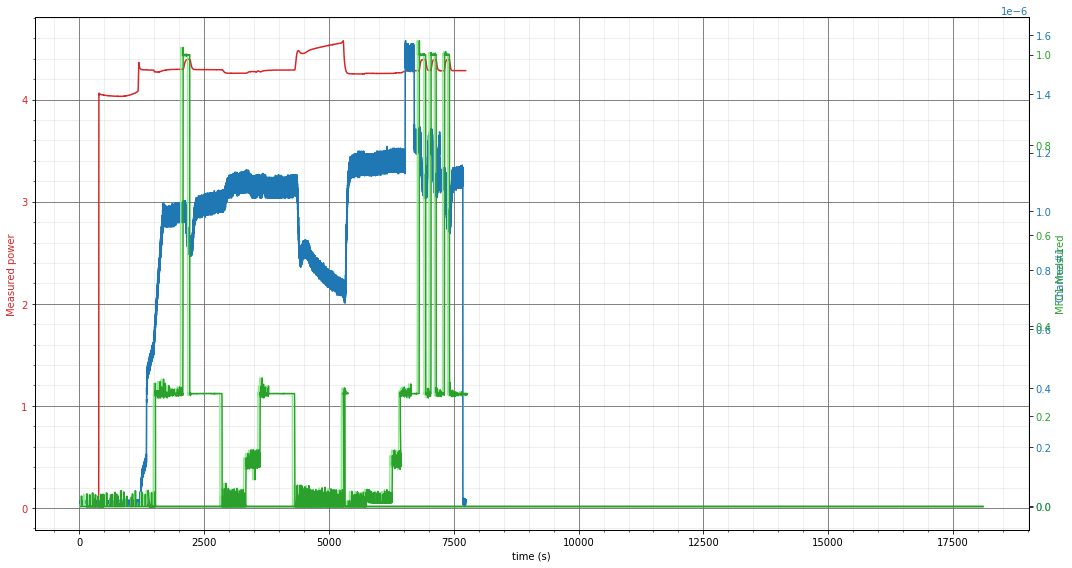

<Figure size 432x288 with 0 Axes>

In [12]:
plotOneParameter = 'Measured power'
plotTwoParameter = 'Channel#1'
plotThreeParameter ='MFC1 Measured'

fig, ax1 = plt.subplots(figsize=(15,8))
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel(plotOneParameter, color=color)
ax1.plot(inTemData['Experiment time'],inTemData[plotOneParameter], color=color)
ax1.tick_params(axis='y', labelcolor=color)


if afterTemData is not None:
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(plotTwoParameter, color=color)
    ax2.plot(afterTemData['Experiment time'],afterTemData[plotTwoParameter], color='lightblue')
    ax2.plot(afterTemDataCorrected['Experiment time'],afterTemDataCorrected[plotTwoParameter], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
color = 'tab:green'
ax3.set_ylabel(plotThreeParameter,color=color)
ax3.plot(beforeTemData['Experiment time'],beforeTemData[plotThreeParameter],  color='lightgreen')
ax3.plot(beforeTemDataCorrected['Experiment time'],beforeTemDataCorrected[plotThreeParameter],  color=color)
ax3.tick_params(axis='y', labelcolor=color)
plt.tight_layout()

ax1.grid(b=True, which='major', color='#666666', linestyle='-')
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
ax1.autoscale()
ax2.autoscale()
ax3.autoscale()
#plt.xlim(2000,2500) # Use this to zoom into a certain section of the graph
plt.show()
plt.clf()

## Part 7. Save new CSV files

To save the corrected CSV files, run the code below.

In [8]:
# Paths and filenames
experimentName = os.path.splitext(impulseLogfilePath.name)[0]
correctedDataFolder = os.path.dirname(impulseLogfilePath)#+"/"+experimentName+"_corrected-data"
Path(correctedDataFolder).mkdir(parents=True, exist_ok=True) # Create corrected-data folder

#Create the CSV files
inTemData.to_csv((correctedDataFolder+'/'+experimentName+'_corrected-inside.csv'), index=False)
beforeTemData.to_csv((correctedDataFolder+'/'+experimentName+'_corrected-before.csv'), index=False)            
if afterTemData is not None: afterTemData.to_csv((correctedDataFolder+'/'+experimentName+'_corrected-after.csv'), index=False)
   
beforeTemDataCorrected = beforeTemDataCorrected.sort_values(by = 'Experiment time')
inTemData = inTemData.sort_values(by = 'Experiment time')
syncData = pd.merge_asof(inTemData, beforeTemDataCorrected, on = 'Experiment time')
if afterTemData is not None:
    afterTemDataCorrected = afterTemDataCorrected.sort_values(by = 'Experiment time')
    syncData = pd.merge_asof(syncData, afterTemDataCorrected, on = 'Experiment time')

syncData.to_csv((correctedDataFolder+'/'+experimentName+'_corrected-synchronized.csv'), index=False)
